In [1]:
# import python packages
import warnings
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import xarray as xr
from shapely.geometry import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# ignoring shapely future warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [3]:
# function for later scaling
def minmaxscale(array):
    """
    Min-max scaling of data
    """
    return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))

In [4]:
# storm report data
svstorms = pd.read_csv('/Users/molina/Desktop/tstorms_md_jan2019-jul2022.csv')
svstorms = svstorms[
    (pd.to_datetime(svstorms['BEGIN_DATE']).dt.month >= 4) & (
        pd.to_datetime(svstorms['BEGIN_DATE']).dt.month <= 7)]

# edu and res centers
md_pb4yr = pd.read_csv('/Users/molina/Desktop/MD_Higher_Education_(Public_Four_Year).csv')
md_pb2yr = pd.read_csv('/Users/molina/Desktop/MD_Higher_Education_(Public_Two_Year).csv')
md_regio = pd.read_csv('/Users/molina/Desktop/MD_Higher_Education_(Regional_Education_Centers).csv')
md_envlb = pd.read_excel('/Users/molina/Desktop/md_env_lab.xlsx')
md_agres = pd.read_excel('/Users/molina/Desktop/agresearch.xlsx')

md_2020pop = pd.read_csv(
    '/Users/molina/Desktop/ACSDP5Y2020.DP05_2022-11-19T001636/ACSDP5Y2020.DP05-Data.csv', 
    header=0).drop(0).reset_index()

In [5]:
recs_md = pd.read_csv('/Users/molina/Desktop/initialround-mdmeso.csv')

In [6]:
recs_md

,County,Zip Code,Site,Lat,Lon,Loc,Notes,Unnamed: 7,Unnamed: 8
0,Allegany,21532,Frostburg University,39.649503,-78.932751,1,NaN,NaN,NaN
1,Anne Arundel,21061,tbd,39.161463,-76.631489,0,NaN,NaN,NaN
2,Anne Arundel,21402,tbd,38.984400,-76.488900,0,21401/21402/21402; United States Naval Academy...,NaN,NaN
3,Baltimore,21252,Towson University,39.394852,-76.616388,1,NaN,NaN,NaN
4,Baltimore,21250,University of Maryland - Baltimore County,39.253028,-76.713549,1,NaN,NaN,NaN
5,Baltimore City,21251,Morgan State University,39.339212,-76.581519,1,NaN,NaN,NaN
6,Calvert,20678,College of Southern Maryland - Prince Frederick,38.535051,-76.607470,1,NaN,NaN,NaN
7,Caroline,21660,tbd,38.945746,-75.858548,0,Eastern side of the zip code region,NaN,NaN
8,Carroll,21157,tbd,39.619828,-76.946849,0,Northern side of zip code region,NaN,NaN
9,Cecil,21901,Cecil College,39.641074,-75.956434,1,NaN,NaN,NaN


In [7]:
# county shapefiles
md_counties = gpd.read_file('/Users/molina/Desktop/tl_2021_us_county/tl_2021_us_county.shp')
md_counties = md_counties.loc[md_counties['STATEFP']=='24']

# load state shapefiles
md_state = gpd.read_file('/Users/molina/Desktop/tl_2022_us_state/tl_2022_us_state.shp')
md_state = md_state[md_state['NAME'] == 'Maryland']

In [8]:
# load data from imap
md_zcta_census = gpd.read_file(
    '/Users/molina/Desktop/Maryland_Census_Data_-_ZIP_Code_Tabulation_Areas_(ZCTAs)/DEMO_CensusDataZCTA_MDP.shp')
# print(md_zcta_census.crs)

# convert projection
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    md_zcta_census = md_zcta_census.to_crs({'init': 'epsg:4326'})
    # print(md_zcta_census.crs)

In [9]:
# total population
md_zcta_census['newpop'] = md_2020pop['DP05_0001E'].astype(float)

# margin of error (+/-)
md_zcta_census['newpop_merr'] = md_2020pop['DP05_0001M'].astype(float)

# compute population normalized by land area
md_zcta_census['popnormbyarea'] = md_zcta_census['newpop'] / (md_zcta_census['AREALAND'] / 1000)

# compute population normalized by land area
md_zcta_census['oldpopnormbyarea'] = md_zcta_census['POP100'] / (md_zcta_census['AREALAND'] / 1000)

In [10]:
select_zcta = md_zcta_census[
    np.isin(md_zcta_census['ZCTA5CE10'].astype(int), recs_md['Zip Code'].astype(int))]

In [11]:
picked_locs = recs_md[recs_md['Loc']==1]
notpickeds_ = recs_md[recs_md['Loc']==0]

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



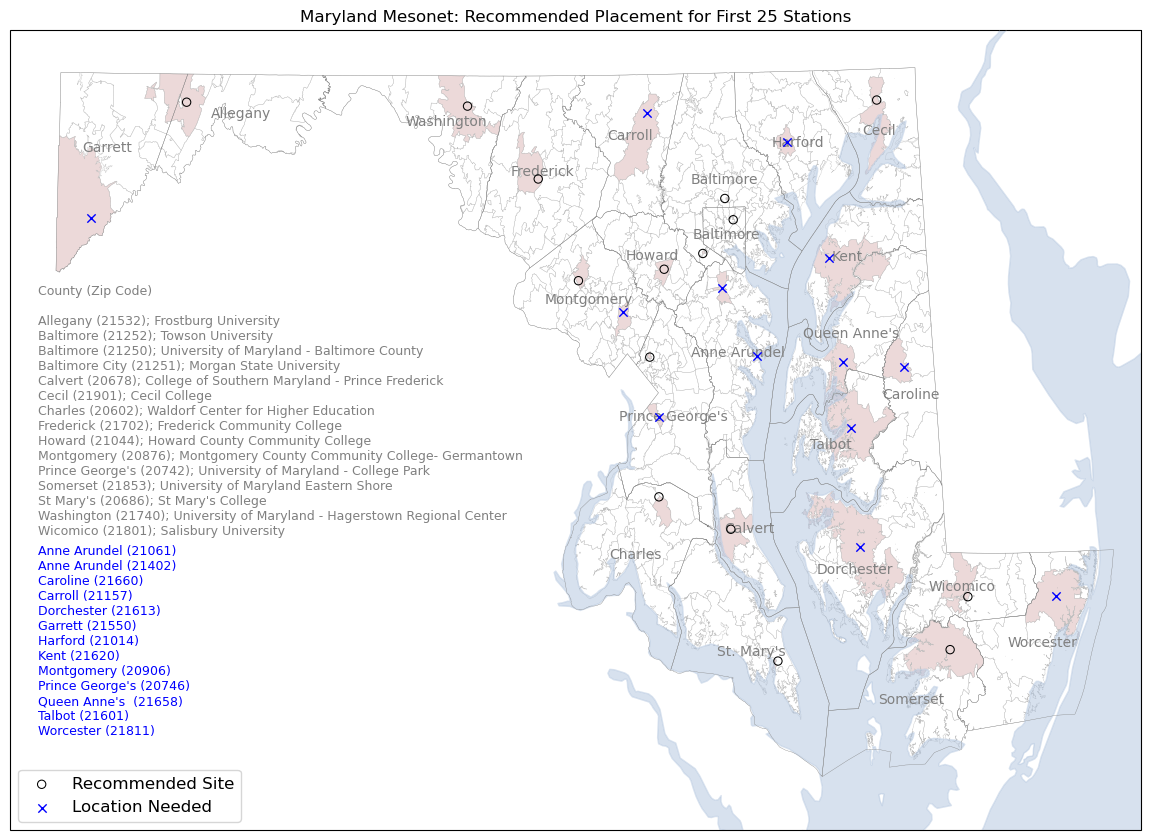

In [34]:
# population
fig = plt.figure(figsize=(12,8))

ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Maryland Mesonet: Recommended Placement for First 25 Stations', fontsize=12)


# selected zip codes
select_zcta.plot(ax=ax, transform=ccrs.PlateCarree(),
                 legend=True, edgecolor='maroon', facecolor='maroon', lw=0.1, alpha=0.15, figsize=(12,8))

# zip codes
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(),
                    legend=True, edgecolor='silver', facecolor='none', lw=0.25, figsize=(12,8))


# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='grey', lw=0.25, zorder=100)

# county names
for md_x, md_y, md_n in zip(md_counties.geometry.centroid.x, 
                            md_counties.geometry.centroid.y, md_counties['NAME']):

    ax.text(md_x, md_y, md_n, color='grey', size=10, ha='center', va='center', 
            transform=ccrs.PlateCarree(), zorder=100)

    
# site annotation listing
ax.annotate(
    f'County (Zip Code)\n'\
    f'\n'\
    f'{picked_locs["County"].values[0]} ({picked_locs["Zip Code"].values[0]}); {picked_locs["Site"].values[0]}\n'\
    f'{picked_locs["County"].values[1]} ({picked_locs["Zip Code"].values[1]}); {picked_locs["Site"].values[1]}\n'\
    f'{picked_locs["County"].values[2]} ({picked_locs["Zip Code"].values[2]}); {picked_locs["Site"].values[2]}\n'\
    f'{picked_locs["County"].values[3]} ({picked_locs["Zip Code"].values[3]}); {picked_locs["Site"].values[3]}\n'\
    f'{picked_locs["County"].values[4]} ({picked_locs["Zip Code"].values[4]}); {picked_locs["Site"].values[4]}\n'\
    f'{picked_locs["County"].values[5]} ({picked_locs["Zip Code"].values[5]}); {picked_locs["Site"].values[5]}\n'\
    f'{picked_locs["County"].values[6]} ({picked_locs["Zip Code"].values[6]}); {picked_locs["Site"].values[6]}\n'\
    f'{picked_locs["County"].values[7]} ({picked_locs["Zip Code"].values[7]}); {picked_locs["Site"].values[7]}\n'\
    f'{picked_locs["County"].values[8]} ({picked_locs["Zip Code"].values[8]}); {picked_locs["Site"].values[8]}\n'\
    f'{picked_locs["County"].values[9]} ({picked_locs["Zip Code"].values[9]}); {picked_locs["Site"].values[9]}\n'\
    f'{picked_locs["County"].values[10]} ({picked_locs["Zip Code"].values[10]}); {picked_locs["Site"].values[10]}\n'\
    f'{picked_locs["County"].values[11]} ({picked_locs["Zip Code"].values[11]}); {picked_locs["Site"].values[11]}\n'\
    f'{picked_locs["County"].values[12]} ({picked_locs["Zip Code"].values[12]}); {picked_locs["Site"].values[12]}\n'\
    f'{picked_locs["County"].values[13]} ({picked_locs["Zip Code"].values[13]}); {picked_locs["Site"].values[13]}\n'\
    f'{picked_locs["County"].values[14]} ({picked_locs["Zip Code"].values[14]}); {picked_locs["Site"].values[14]}\n',
    
    xy=(0.025, 0.35), xycoords='axes fraction', fontsize=9, fontweight='ultralight', color='grey')


# site annotation listing
ax.annotate(
    f'{notpickeds_["County"].values[0]} ({notpickeds_["Zip Code"].values[0]})\n'\
    f'{notpickeds_["County"].values[1]} ({notpickeds_["Zip Code"].values[1]})\n'\
    f'{notpickeds_["County"].values[2]} ({notpickeds_["Zip Code"].values[2]})\n'\
    f'{notpickeds_["County"].values[3]} ({notpickeds_["Zip Code"].values[3]})\n'\
    f'{notpickeds_["County"].values[4]} ({notpickeds_["Zip Code"].values[4]})\n'\
    f'{notpickeds_["County"].values[5]} ({notpickeds_["Zip Code"].values[5]})\n'\
    f'{notpickeds_["County"].values[6]} ({notpickeds_["Zip Code"].values[6]})\n'\
    f'{notpickeds_["County"].values[7]} ({notpickeds_["Zip Code"].values[7]})\n'\
    f'{notpickeds_["County"].values[8]} ({notpickeds_["Zip Code"].values[8]})\n'\
    f'{notpickeds_["County"].values[9]} ({notpickeds_["Zip Code"].values[9]})\n'\
    f'{notpickeds_["County"].values[10]} ({notpickeds_["Zip Code"].values[10]})\n'\
    f'{notpickeds_["County"].values[11]} ({notpickeds_["Zip Code"].values[11]})\n'\
    f'{notpickeds_["County"].values[12]} ({notpickeds_["Zip Code"].values[12]})\n',
    
    xy=(0.025, 0.1), xycoords='axes fraction', fontsize=9, fontweight='ultralight', color='b')


# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='w', linewidth=0.1, zorder=100)

# ocean
ax.add_feature(
    cfeature.NaturalEarthFeature(
        'physical', 'ocean', '10m', edgecolor='face', facecolor='lightsteelblue', alpha=0.5))

# land
#ax.add_feature(
#    cfeature.NaturalEarthFeature(
#        'physical', 'land', '10m', edgecolor='face', facecolor='linen', alpha=0.5))


# possible public locs with locs identified
for i, j in zip(picked_locs['Lon'].values, picked_locs['Lat'].values):
    
    yl = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=100, marker='o', facecolor='none', edgecolor='k', lw=0.75)
    
    
# possible public locs (need to identify locs)
for i, j in zip(notpickeds_['Lon'].values, notpickeds_['Lat'].values):
    
    nl = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=100, marker='x', color='b', lw=1.0)

    
# legend 
ax.legend([yl, nl], ['Recommended Site', 'Location Needed'], fancybox=True, loc='lower left', fontsize=12)
    
    
# map extent
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

plt.savefig('/Users/molina/Desktop/mdmeso_rec1.png', bbox_inches='tight', dpi=200)
plt.show()

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



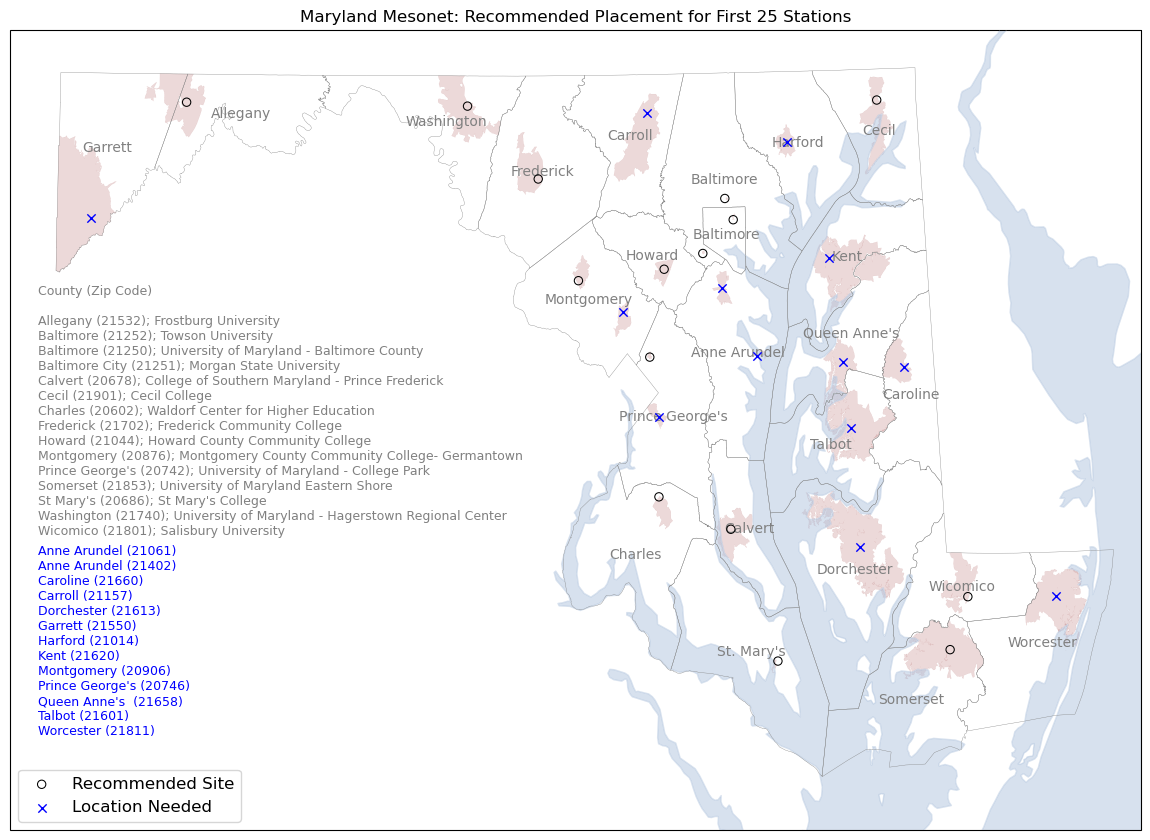

In [33]:
# population
fig = plt.figure(figsize=(12,8))

ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Maryland Mesonet: Recommended Placement for First 25 Stations', fontsize=12)


# selected zip codes
select_zcta.plot(ax=ax, transform=ccrs.PlateCarree(),
                 legend=True, edgecolor='maroon', facecolor='maroon', lw=0.15, alpha=0.15, figsize=(12,8))

# zip codes
#md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(),
#                    legend=True, edgecolor='silver', facecolor='none', lw=0.5, figsize=(12,8))


# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='grey', lw=0.25, zorder=100)

# county names
for md_x, md_y, md_n in zip(md_counties.geometry.centroid.x, 
                            md_counties.geometry.centroid.y, md_counties['NAME']):

    ax.text(md_x, md_y, md_n, color='grey', size=10, ha='center', va='center', 
            transform=ccrs.PlateCarree(), zorder=100)

    
# site annotation listing
ax.annotate(
    f'County (Zip Code)\n'\
    f'\n'\
    f'{picked_locs["County"].values[0]} ({picked_locs["Zip Code"].values[0]}); {picked_locs["Site"].values[0]}\n'\
    f'{picked_locs["County"].values[1]} ({picked_locs["Zip Code"].values[1]}); {picked_locs["Site"].values[1]}\n'\
    f'{picked_locs["County"].values[2]} ({picked_locs["Zip Code"].values[2]}); {picked_locs["Site"].values[2]}\n'\
    f'{picked_locs["County"].values[3]} ({picked_locs["Zip Code"].values[3]}); {picked_locs["Site"].values[3]}\n'\
    f'{picked_locs["County"].values[4]} ({picked_locs["Zip Code"].values[4]}); {picked_locs["Site"].values[4]}\n'\
    f'{picked_locs["County"].values[5]} ({picked_locs["Zip Code"].values[5]}); {picked_locs["Site"].values[5]}\n'\
    f'{picked_locs["County"].values[6]} ({picked_locs["Zip Code"].values[6]}); {picked_locs["Site"].values[6]}\n'\
    f'{picked_locs["County"].values[7]} ({picked_locs["Zip Code"].values[7]}); {picked_locs["Site"].values[7]}\n'\
    f'{picked_locs["County"].values[8]} ({picked_locs["Zip Code"].values[8]}); {picked_locs["Site"].values[8]}\n'\
    f'{picked_locs["County"].values[9]} ({picked_locs["Zip Code"].values[9]}); {picked_locs["Site"].values[9]}\n'\
    f'{picked_locs["County"].values[10]} ({picked_locs["Zip Code"].values[10]}); {picked_locs["Site"].values[10]}\n'\
    f'{picked_locs["County"].values[11]} ({picked_locs["Zip Code"].values[11]}); {picked_locs["Site"].values[11]}\n'\
    f'{picked_locs["County"].values[12]} ({picked_locs["Zip Code"].values[12]}); {picked_locs["Site"].values[12]}\n'\
    f'{picked_locs["County"].values[13]} ({picked_locs["Zip Code"].values[13]}); {picked_locs["Site"].values[13]}\n'\
    f'{picked_locs["County"].values[14]} ({picked_locs["Zip Code"].values[14]}); {picked_locs["Site"].values[14]}\n',
    
    xy=(0.025, 0.35), xycoords='axes fraction', fontsize=9, fontweight='ultralight', color='grey')


# site annotation listing
ax.annotate(
    f'{notpickeds_["County"].values[0]} ({notpickeds_["Zip Code"].values[0]})\n'\
    f'{notpickeds_["County"].values[1]} ({notpickeds_["Zip Code"].values[1]})\n'\
    f'{notpickeds_["County"].values[2]} ({notpickeds_["Zip Code"].values[2]})\n'\
    f'{notpickeds_["County"].values[3]} ({notpickeds_["Zip Code"].values[3]})\n'\
    f'{notpickeds_["County"].values[4]} ({notpickeds_["Zip Code"].values[4]})\n'\
    f'{notpickeds_["County"].values[5]} ({notpickeds_["Zip Code"].values[5]})\n'\
    f'{notpickeds_["County"].values[6]} ({notpickeds_["Zip Code"].values[6]})\n'\
    f'{notpickeds_["County"].values[7]} ({notpickeds_["Zip Code"].values[7]})\n'\
    f'{notpickeds_["County"].values[8]} ({notpickeds_["Zip Code"].values[8]})\n'\
    f'{notpickeds_["County"].values[9]} ({notpickeds_["Zip Code"].values[9]})\n'\
    f'{notpickeds_["County"].values[10]} ({notpickeds_["Zip Code"].values[10]})\n'\
    f'{notpickeds_["County"].values[11]} ({notpickeds_["Zip Code"].values[11]})\n'\
    f'{notpickeds_["County"].values[12]} ({notpickeds_["Zip Code"].values[12]})\n',
    
    xy=(0.025, 0.1), xycoords='axes fraction', fontsize=9, fontweight='ultralight', color='b')


# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='w', linewidth=0.1, zorder=100)

# ocean
ax.add_feature(
    cfeature.NaturalEarthFeature(
        'physical', 'ocean', '10m', edgecolor='face', facecolor='lightsteelblue', alpha=0.5))

# land
#ax.add_feature(
#    cfeature.NaturalEarthFeature(
#        'physical', 'land', '10m', edgecolor='face', facecolor='linen', alpha=0.5))


# possible public locs with locs identified
for i, j in zip(picked_locs['Lon'].values, picked_locs['Lat'].values):
    
    yl = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=100, marker='o', facecolor='none', edgecolor='k', lw=0.75)
    
    
# possible public locs (need to identify locs)
for i, j in zip(notpickeds_['Lon'].values, notpickeds_['Lat'].values):
    
    nl = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=100, marker='x', color='b', lw=1.0)

    
# legend 
ax.legend([yl, nl], ['Recommended Site', 'Location Needed'], fancybox=True, loc='lower left', fontsize=12)
    
    
# map extent
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

plt.savefig('/Users/molina/Desktop/mdmeso_rec2.png', bbox_inches='tight', dpi=200)
plt.show()

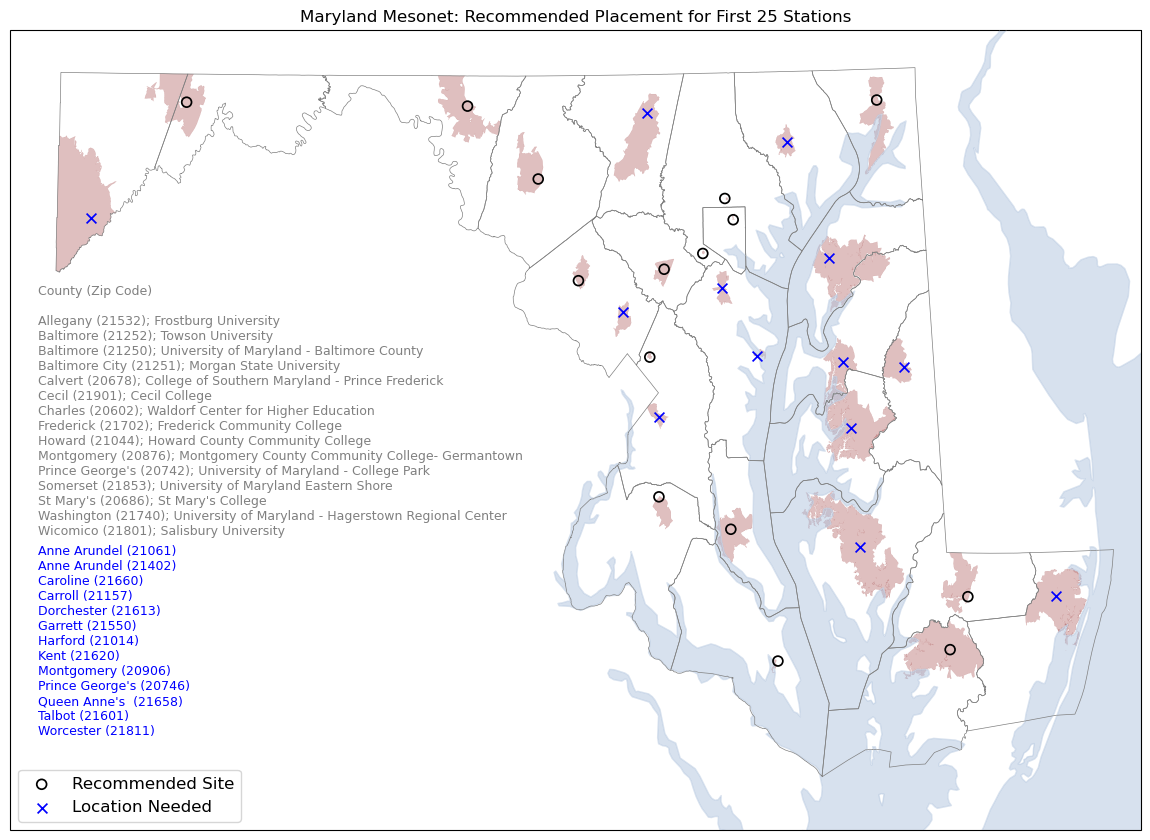

In [32]:
# population
fig = plt.figure(figsize=(12,8))

ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Maryland Mesonet: Recommended Placement for First 25 Stations', fontsize=12)


# selected zip codes
select_zcta.plot(ax=ax, transform=ccrs.PlateCarree(),
                 legend=True, edgecolor='maroon', facecolor='maroon', lw=0.15, alpha=0.25, figsize=(12,8))

# zip codes
#md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(),
#                    legend=True, edgecolor='silver', facecolor='none', lw=0.5, figsize=(12,8))


# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='grey', lw=0.5, zorder=100)

# county names
#for md_x, md_y, md_n in zip(md_counties.geometry.centroid.x, 
#                            md_counties.geometry.centroid.y, md_counties['NAME']):

#    ax.text(md_x, md_y, md_n, color='grey', size=10, ha='center', va='center', 
#            transform=ccrs.PlateCarree(), zorder=100)

    
# site annotation listing
ax.annotate(
    f'County (Zip Code)\n'\
    f'\n'\
    f'{picked_locs["County"].values[0]} ({picked_locs["Zip Code"].values[0]}); {picked_locs["Site"].values[0]}\n'\
    f'{picked_locs["County"].values[1]} ({picked_locs["Zip Code"].values[1]}); {picked_locs["Site"].values[1]}\n'\
    f'{picked_locs["County"].values[2]} ({picked_locs["Zip Code"].values[2]}); {picked_locs["Site"].values[2]}\n'\
    f'{picked_locs["County"].values[3]} ({picked_locs["Zip Code"].values[3]}); {picked_locs["Site"].values[3]}\n'\
    f'{picked_locs["County"].values[4]} ({picked_locs["Zip Code"].values[4]}); {picked_locs["Site"].values[4]}\n'\
    f'{picked_locs["County"].values[5]} ({picked_locs["Zip Code"].values[5]}); {picked_locs["Site"].values[5]}\n'\
    f'{picked_locs["County"].values[6]} ({picked_locs["Zip Code"].values[6]}); {picked_locs["Site"].values[6]}\n'\
    f'{picked_locs["County"].values[7]} ({picked_locs["Zip Code"].values[7]}); {picked_locs["Site"].values[7]}\n'\
    f'{picked_locs["County"].values[8]} ({picked_locs["Zip Code"].values[8]}); {picked_locs["Site"].values[8]}\n'\
    f'{picked_locs["County"].values[9]} ({picked_locs["Zip Code"].values[9]}); {picked_locs["Site"].values[9]}\n'\
    f'{picked_locs["County"].values[10]} ({picked_locs["Zip Code"].values[10]}); {picked_locs["Site"].values[10]}\n'\
    f'{picked_locs["County"].values[11]} ({picked_locs["Zip Code"].values[11]}); {picked_locs["Site"].values[11]}\n'\
    f'{picked_locs["County"].values[12]} ({picked_locs["Zip Code"].values[12]}); {picked_locs["Site"].values[12]}\n'\
    f'{picked_locs["County"].values[13]} ({picked_locs["Zip Code"].values[13]}); {picked_locs["Site"].values[13]}\n'\
    f'{picked_locs["County"].values[14]} ({picked_locs["Zip Code"].values[14]}); {picked_locs["Site"].values[14]}\n',
    
    xy=(0.025, 0.35), xycoords='axes fraction', fontsize=9, fontweight='ultralight', color='grey')


# site annotation listing
ax.annotate(
    f'{notpickeds_["County"].values[0]} ({notpickeds_["Zip Code"].values[0]})\n'\
    f'{notpickeds_["County"].values[1]} ({notpickeds_["Zip Code"].values[1]})\n'\
    f'{notpickeds_["County"].values[2]} ({notpickeds_["Zip Code"].values[2]})\n'\
    f'{notpickeds_["County"].values[3]} ({notpickeds_["Zip Code"].values[3]})\n'\
    f'{notpickeds_["County"].values[4]} ({notpickeds_["Zip Code"].values[4]})\n'\
    f'{notpickeds_["County"].values[5]} ({notpickeds_["Zip Code"].values[5]})\n'\
    f'{notpickeds_["County"].values[6]} ({notpickeds_["Zip Code"].values[6]})\n'\
    f'{notpickeds_["County"].values[7]} ({notpickeds_["Zip Code"].values[7]})\n'\
    f'{notpickeds_["County"].values[8]} ({notpickeds_["Zip Code"].values[8]})\n'\
    f'{notpickeds_["County"].values[9]} ({notpickeds_["Zip Code"].values[9]})\n'\
    f'{notpickeds_["County"].values[10]} ({notpickeds_["Zip Code"].values[10]})\n'\
    f'{notpickeds_["County"].values[11]} ({notpickeds_["Zip Code"].values[11]})\n'\
    f'{notpickeds_["County"].values[12]} ({notpickeds_["Zip Code"].values[12]})\n',
    
    xy=(0.025, 0.1), xycoords='axes fraction', fontsize=9, fontweight='ultralight', color='b')


# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='w', linewidth=0.1, zorder=100)

# ocean
ax.add_feature(
    cfeature.NaturalEarthFeature(
        'physical', 'ocean', '10m', edgecolor='face', facecolor='lightsteelblue', alpha=0.5))

# land
#ax.add_feature(
#    cfeature.NaturalEarthFeature(
#        'physical', 'land', '10m', edgecolor='face', facecolor='linen', alpha=0.5))


# possible public locs with locs identified
for i, j in zip(picked_locs['Lon'].values, picked_locs['Lat'].values):
    
    yl = ax.scatter(
        i, j, s=50, transform=ccrs.PlateCarree(), zorder=100, marker='o', facecolor='none', edgecolor='k', lw=1.25)
    
    
# possible public locs (need to identify locs)
for i, j in zip(notpickeds_['Lon'].values, notpickeds_['Lat'].values):
    
    nl = ax.scatter(i, j, s=50, transform=ccrs.PlateCarree(), zorder=100, marker='x', color='b', lw=1.25)

    
# legend 
ax.legend([yl, nl], ['Recommended Site', 'Location Needed'], fancybox=True, loc='lower left', fontsize=12)
    
    
# map extent
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

plt.savefig('/Users/molina/Desktop/mdmeso_rec3.png', bbox_inches='tight', dpi=200)
plt.show()

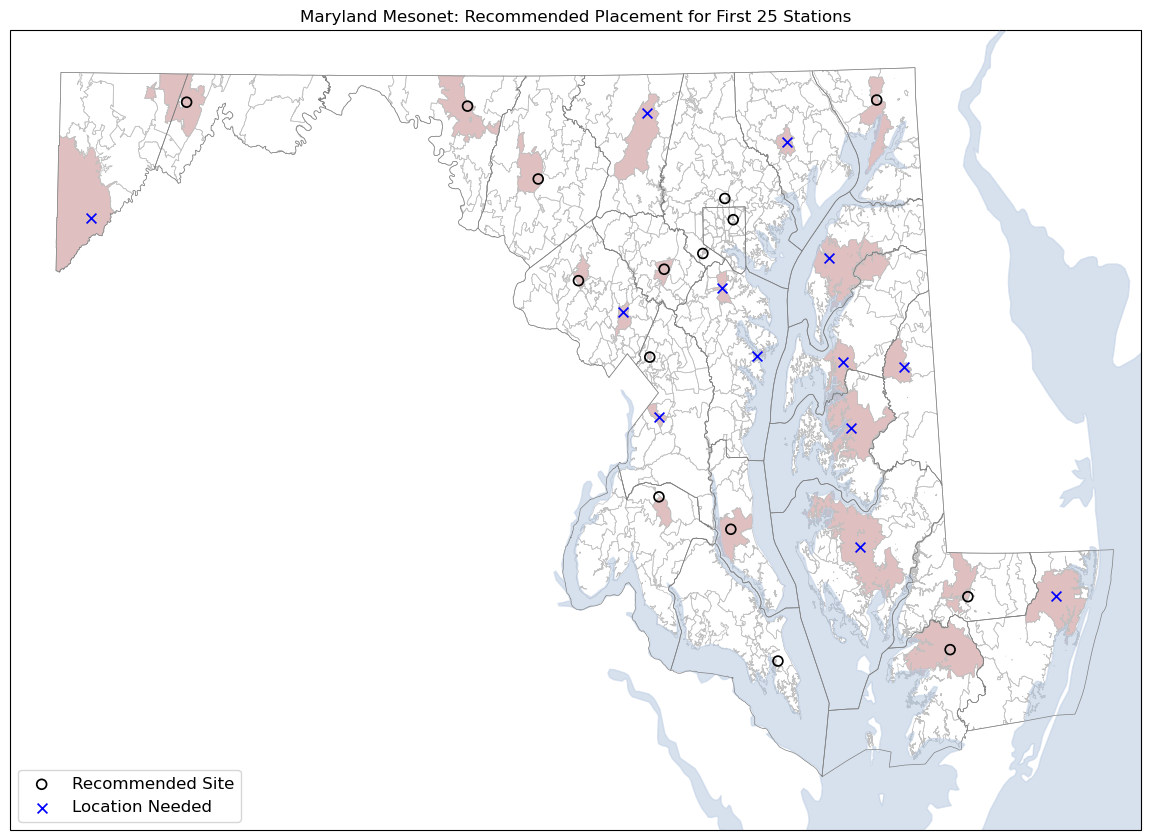

In [27]:
# population
fig = plt.figure(figsize=(12,8))

ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Maryland Mesonet: Recommended Placement for First 25 Stations', fontsize=12)


# selected zip codes
select_zcta.plot(ax=ax, transform=ccrs.PlateCarree(),
                 legend=True, edgecolor='maroon', facecolor='maroon', lw=0.15, alpha=0.25, figsize=(12,8))

# zip codes
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(),
                    legend=True, edgecolor='silver', facecolor='none', lw=0.5, figsize=(12,8))


# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='grey', lw=0.5, zorder=100)

# county names
#for md_x, md_y, md_n in zip(md_counties.geometry.centroid.x, 
#                            md_counties.geometry.centroid.y, md_counties['NAME']):

#    ax.text(md_x, md_y, md_n, color='grey', size=10, ha='center', va='center', 
#            transform=ccrs.PlateCarree(), zorder=100)


# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='w', linewidth=0.1, zorder=100)

# ocean
ax.add_feature(
    cfeature.NaturalEarthFeature(
        'physical', 'ocean', '10m', edgecolor='face', facecolor='lightsteelblue', alpha=0.5))

# land
#ax.add_feature(
#    cfeature.NaturalEarthFeature(
#        'physical', 'land', '10m', edgecolor='face', facecolor='linen', alpha=0.5))


# possible public locs with locs identified
for i, j in zip(picked_locs['Lon'].values, picked_locs['Lat'].values):
    
    yl = ax.scatter(
        i, j, s=50, transform=ccrs.PlateCarree(), zorder=100, marker='o', facecolor='none', edgecolor='k', lw=1.25)
    
    
# possible public locs (need to identify locs)
for i, j in zip(notpickeds_['Lon'].values, notpickeds_['Lat'].values):
    
    nl = ax.scatter(i, j, s=50, transform=ccrs.PlateCarree(), zorder=100, marker='x', color='b', lw=1.25)

    
# legend 
ax.legend([yl, nl], ['Recommended Site', 'Location Needed'], fancybox=True, loc='lower left', fontsize=12)
    
    
# map extent
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

plt.savefig('/Users/molina/Desktop/mdmeso_rec4.png', bbox_inches='tight', dpi=200)
plt.show()

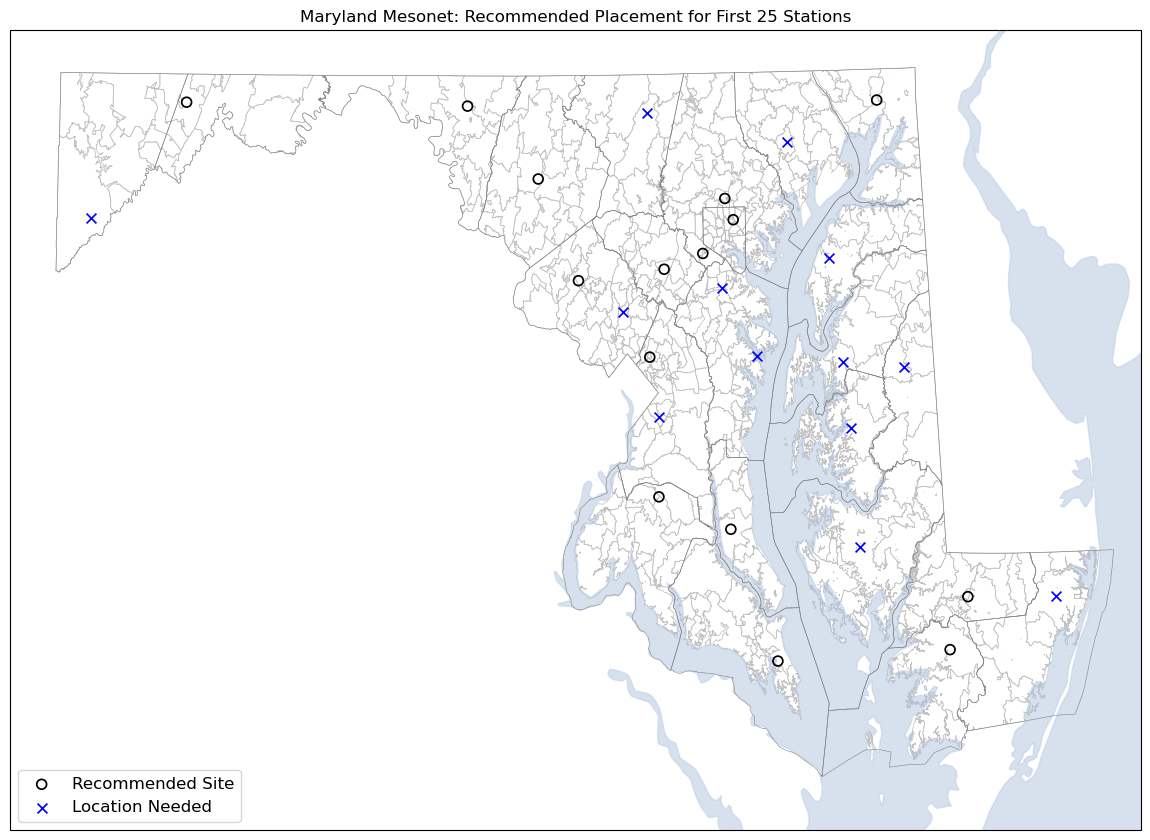

In [28]:
# population
fig = plt.figure(figsize=(12,8))

ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Maryland Mesonet: Recommended Placement for First 25 Stations', fontsize=12)


# selected zip codes
#select_zcta.plot(ax=ax, transform=ccrs.PlateCarree(),
#                 legend=True, edgecolor='maroon', facecolor='maroon', lw=0.15, alpha=0.5, figsize=(12,8))

# zip codes
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(),
                    legend=True, edgecolor='silver', facecolor='none', lw=0.5, figsize=(12,8))


# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='grey', lw=0.4, zorder=100)

# county names
#for md_x, md_y, md_n in zip(md_counties.geometry.centroid.x, 
#                            md_counties.geometry.centroid.y, md_counties['NAME']):

#    ax.text(md_x, md_y, md_n, color='grey', size=10, ha='center', va='center', 
#            transform=ccrs.PlateCarree(), zorder=100)


# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='w', linewidth=0.1, zorder=100)

# ocean
ax.add_feature(
    cfeature.NaturalEarthFeature(
        'physical', 'ocean', '10m', edgecolor='face', facecolor='lightsteelblue', alpha=0.5))

# land
#ax.add_feature(
#    cfeature.NaturalEarthFeature(
#        'physical', 'land', '10m', edgecolor='face', facecolor='linen', alpha=0.5))


# possible public locs with locs identified
for i, j in zip(picked_locs['Lon'].values, picked_locs['Lat'].values):
    
    yl = ax.scatter(
        i, j, s=50, 
        transform=ccrs.PlateCarree(), zorder=100, marker='o', facecolor='none', edgecolor='k', lw=1.25)
    
    
# possible public locs (need to identify locs)
for i, j in zip(notpickeds_['Lon'].values, notpickeds_['Lat'].values):
    
    nl = ax.scatter(i, j, s=50, transform=ccrs.PlateCarree(), zorder=100, marker='x', color='b', lw=1.25)

    
# legend 
ax.legend([yl, nl], ['Recommended Site', 'Location Needed'], fancybox=True, loc='lower left', fontsize=12)
    
    
# map extent
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

plt.savefig('/Users/molina/Desktop/mdmeso_rec5.png', bbox_inches='tight', dpi=200)
plt.show()

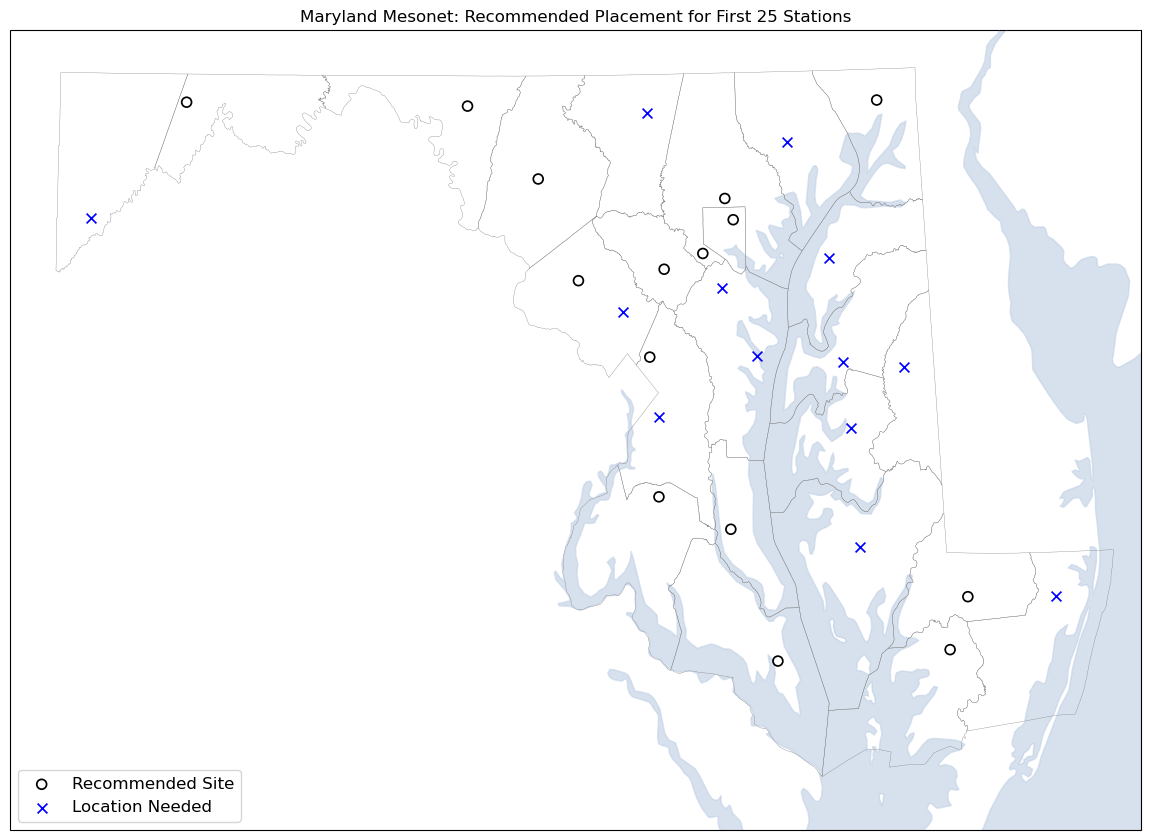

In [29]:
# population
fig = plt.figure(figsize=(12,8))

ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Maryland Mesonet: Recommended Placement for First 25 Stations', fontsize=12)


# selected zip codes
#select_zcta.plot(ax=ax, transform=ccrs.PlateCarree(),
#                 legend=True, edgecolor='maroon', facecolor='maroon', lw=0.15, alpha=0.5, figsize=(12,8))

# zip codes
#md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(),
#                    legend=True, edgecolor='silver', facecolor='none', lw=0.5, figsize=(12,8))


# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='grey', lw=0.25, zorder=100)

# county names
#for md_x, md_y, md_n in zip(md_counties.geometry.centroid.x, 
#                            md_counties.geometry.centroid.y, md_counties['NAME']):

#    ax.text(md_x, md_y, md_n, color='grey', size=10, ha='center', va='center', 
#            transform=ccrs.PlateCarree(), zorder=100)


# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='w', linewidth=0.1, zorder=100)

# ocean
ax.add_feature(
    cfeature.NaturalEarthFeature(
        'physical', 'ocean', '10m', edgecolor='face', facecolor='lightsteelblue', alpha=0.5))

# land
#ax.add_feature(
#    cfeature.NaturalEarthFeature(
#        'physical', 'land', '10m', edgecolor='face', facecolor='linen', alpha=0.5))


# possible public locs with locs identified
for i, j in zip(picked_locs['Lon'].values, picked_locs['Lat'].values):
    
    yl = ax.scatter(
        i, j, s=50, 
        transform=ccrs.PlateCarree(), zorder=100, marker='o', facecolor='none', edgecolor='k', lw=1.25)
    
    
# possible public locs (need to identify locs)
for i, j in zip(notpickeds_['Lon'].values, notpickeds_['Lat'].values):
    
    nl = ax.scatter(i, j, s=50, transform=ccrs.PlateCarree(), zorder=100, marker='x', color='b', lw=1.25)

    
# legend 
ax.legend([yl, nl], ['Recommended Site', 'Location Needed'], fancybox=True, loc='lower left', fontsize=12)
    
    
# map extent
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

plt.savefig('/Users/molina/Desktop/mdmeso_rec6.png', bbox_inches='tight', dpi=200)
plt.show()

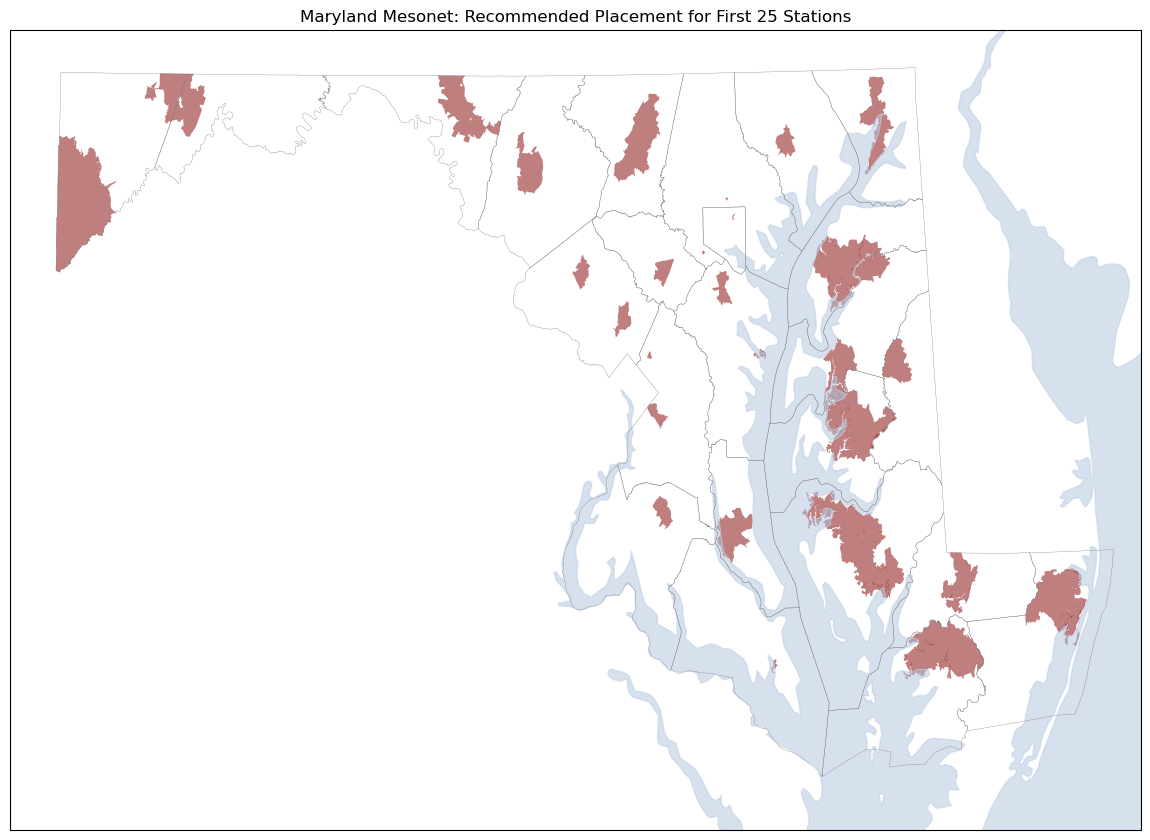

In [30]:
# population
fig = plt.figure(figsize=(12,8))

ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Maryland Mesonet: Recommended Placement for First 25 Stations', fontsize=12)


# selected zip codes
select_zcta.plot(ax=ax, transform=ccrs.PlateCarree(),
                 legend=True, edgecolor='maroon', facecolor='maroon', lw=0.15, alpha=0.5, figsize=(12,8))

# zip codes
#md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(),
#                    legend=True, edgecolor='silver', facecolor='none', lw=0.5, figsize=(12,8))


# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='grey', lw=0.25, zorder=100)

# county names
#for md_x, md_y, md_n in zip(md_counties.geometry.centroid.x, 
#                            md_counties.geometry.centroid.y, md_counties['NAME']):

#    ax.text(md_x, md_y, md_n, color='grey', size=10, ha='center', va='center', 
#            transform=ccrs.PlateCarree(), zorder=100)


# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='w', linewidth=0.1, zorder=100)

# ocean
ax.add_feature(
    cfeature.NaturalEarthFeature(
        'physical', 'ocean', '10m', edgecolor='face', facecolor='lightsteelblue', alpha=0.5))

# land
#ax.add_feature(
#    cfeature.NaturalEarthFeature(
#        'physical', 'land', '10m', edgecolor='face', facecolor='linen', alpha=0.5))


# possible public locs with locs identified
#for i, j in zip(picked_locs['Lon'].values, picked_locs['Lat'].values):
    
#    yl = ax.scatter(
#        i, j, s=50, 
#        transform=ccrs.PlateCarree(), zorder=100, marker='o', facecolor='none', edgecolor='k', lw=1.25)
    
    
# possible public locs (need to identify locs)
#for i, j in zip(notpickeds_['Lon'].values, notpickeds_['Lat'].values):
    
#    nl = ax.scatter(i, j, s=50, transform=ccrs.PlateCarree(), zorder=100, marker='x', color='k', lw=1.25)

    
# legend 
#ax.legend([yl, nl], ['Recommended Site', 'Location Needed'], fancybox=True, loc='lower left', fontsize=12)
    
    
# map extent
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

plt.savefig('/Users/molina/Desktop/mdmeso_rec7.png', bbox_inches='tight', dpi=200)
plt.show()